In [2]:
import gymnasium as gym
import bam_gym # you need to import to register
from bam_gym.utils import SampleSaver

import torch
import json

In [3]:
n_arms = 100
n_state = 10
env = gym.make("bam/ContextBandit", n_arms=n_arms, n_state=n_state, seed=1)

In [5]:
saver = SampleSaver("/home/bam/other_bam_packages/bam_gym/dataset",
                 "ContextBandit",
                 "GPU"
                 )

[SampleSaver] Resuming from /home/bam/other_bam_packages/bam_gym/dataset/ContextBandit/GPU/sarsa_0000.jsonl
[SampleSaver] Current counter: 0, current json count: 0


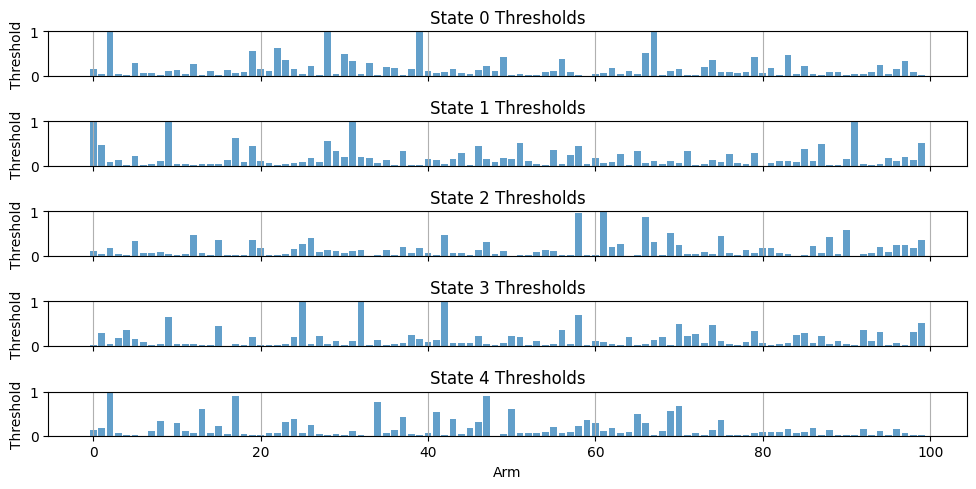

In [6]:
observation, info = env.reset()
env.render()


State 0: Best action is 2 with estimated average reward 1.00
State 1: Best action is 0 with estimated average reward 1.00
State 2: Best action is 58 with estimated average reward 1.00
State 3: Best action is 25 with estimated average reward 1.00
State 4: Best action is 2 with estimated average reward 1.00
State 5: Best action is 24 with estimated average reward 1.00
State 6: Best action is 12 with estimated average reward 1.00
State 7: Best action is 28 with estimated average reward 1.00
State 8: Best action is 10 with estimated average reward 1.00
State 9: Best action is 22 with estimated average reward 1.00

In [23]:
action = env.action_space.sample()

next_observation, reward, terminated, truncated, next_info = env.step(action)

print(f"\nStep Result:")
print(f"Observation: {observation}")
# print(f"Observation: (shape={observation.shape}, dtype={observation.dtype})")
print(f"Action: {action}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")
print(f"Next Observation: {next_observation}")


Step Result:
Observation: 7
Action: 71
Reward: -1
Terminated: True
Truncated: False
Next Observation: 2


In [33]:
for _ in range(1000):
    # action = policy(observation)
    action = env.action_space.sample()

    next_observation, reward, terminated, truncated, next_info = env.step(action)
    saver.save_sample(observation, action, reward, terminated, truncated, info)

    observation = next_observation
    info = next_info

    # Env Auto resets so not needed
    # if (terminated or truncated):
    #     observation, info = env.reset()

env.close()
saver.close()


[SampleSaver] Finished saving 10000 samples.


In [34]:
dataset = []
with open('/home/bam/other_bam_packages/bam_gym/dataset/ContextBandit/GPU/sarsa_0000.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))


print(f"Loaded {len(dataset)} samples.")
print(dataset[0])

Loaded 10000 samples.
{'#': 0, 's': {'obs': 7}, 'a': 86, 'r': 1}


In [35]:
# Counting Solution
reward_sum = torch.zeros((n_state, n_arms), dtype=torch.float32)
action_count = torch.zeros((n_state, n_arms), dtype=torch.float32)

for entry in dataset:
    state = entry['s']['obs']   # Assuming 'obs' is an integer state ID
    action = entry['a']
    reward = entry['r']

    reward_sum[state, action] += reward
    action_count[state, action] += 1

# Avoid division by zero
avg_reward = torch.where(
    action_count > 0,
    reward_sum / action_count,
    torch.zeros_like(reward_sum)
)

print("\nReward Sum Matrix:")
print(reward_sum)

print("\nAverage Reward Matrix:")
print(avg_reward)

# Find best action per state
for state in range(n_state):
    best_action = torch.argmax(avg_reward[state]).item()
    best_reward = avg_reward[state, best_action]
    print(f"State {state}: Best action is {best_action} with estimated average reward {best_reward:.2f}")


Reward Sum Matrix:
tensor([[ -6.,  -8.,  11.,  -5.,  -6.,  -6., -13., -10., -10.,  -5.,  -8.,  -7.,
           0., -11.,  -6.,  -8.,  -4.,  -8.,  -9.,   6.,  -7.,  -8.,  -1.,  -2.,
          -3., -12.,  -3., -13.,  15., -10.,   4.,  -3.,  -4., -12.,  -8., -14.,
          -8., -13.,  -3.,  10., -12.,  -3., -10.,  -8., -10.,  -3., -10.,  -2.,
          -6.,  -6.,  -6.,  -6., -14., -10.,  -5.,  -4.,  -3., -13.,  -9., -16.,
          -8., -11.,  -8.,  -9.,  -3.,  -6.,   3.,   5., -16.,  -7., -10., -10.,
          -8.,  -7., -12.,  -7., -12.,  -8., -10.,   0.,  -6., -10.,  -2.,   2.,
          -9.,  -6., -10.,  -9., -15., -10., -16.,  -6., -11.,  -3., -13., -11.,
          -4.,  -1., -13., -13.],
        [ 12.,  -2.,  -9.,  -8.,  -7.,  -3., -11., -12.,   1.,  11.,  -5.,  -6.,
          -5.,  -9.,  -9., -10.,  -6.,  -2.,  -8.,  -2., -12.,  -9.,  -6.,  -5.,
          -6., -12., -10., -10.,  -2.,  -4.,  -6.,  15.,  -6.,  -6.,  -9.,  -5.,
          -4.,  -6.,  -9.,  -8.,  -5.,  -5., -13.,   0.

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
class SimpleFCN(nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()

        # One-hot input → output actions
        self.fc = nn.Linear(n_states, n_actions, bias=False)  # no bias to match pure s x n weight

    def forward(self, state_index):
        # Convert state index to one-hot
        one_hot = torch.nn.functional.one_hot(state_index, num_classes=self.fc.in_features).float()
        output = self.fc(one_hot)
        return output

In [38]:
model = SimpleFCN(n_state, n_arms)


In [39]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)


https://stats.stackexchange.com/questions/249355/how-exactly-to-compute-deep-q-learning-loss-function

In [40]:
print(model.fc.weight.data)


tensor([[-0.1926,  0.1048,  0.2495, -0.2769,  0.1926, -0.2953, -0.0947,  0.1682,
         -0.2767,  0.1277],
        [-0.0419,  0.0620, -0.1061, -0.1901, -0.0868,  0.0120, -0.1876, -0.2242,
          0.2952,  0.2119],
        [-0.1288, -0.1208, -0.0442, -0.0068,  0.1757,  0.1435, -0.3120, -0.0084,
         -0.1237,  0.0803],
        [ 0.2600,  0.3130,  0.1155,  0.0630, -0.2622, -0.0848,  0.1489,  0.0944,
         -0.2942,  0.2718],
        [ 0.0261, -0.2780, -0.2540,  0.2233,  0.2569,  0.0313,  0.2671, -0.1124,
         -0.1894, -0.0360],
        [-0.2732,  0.1306, -0.1582, -0.2056,  0.1687, -0.1411,  0.1561, -0.2752,
          0.2952, -0.0071],
        [-0.1908,  0.1416, -0.1959,  0.1957,  0.0717,  0.1796, -0.1005, -0.2341,
          0.3157,  0.2994],
        [-0.2818, -0.2477, -0.1936,  0.1350, -0.0120, -0.1384, -0.2503, -0.1631,
         -0.0536, -0.2855],
        [ 0.2927, -0.0436, -0.1158, -0.1449, -0.1914,  0.1973,  0.0842,  0.2156,
          0.1728, -0.0920],
        [ 0.1744,  

In [44]:
for i in range(1000):
    batch_size = 1000

    shuffled_indices = torch.randperm(len(dataset))

    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = shuffled_indices[start_idx:start_idx + batch_size]
        batch = [dataset[i] for i in batch_indices]

        # Extract tensors
        states = torch.tensor([b['s']['obs'] for b in batch], dtype=torch.long)
        actions = torch.tensor([b['a'] for b in batch], dtype=torch.long)
        rewards = torch.tensor([b['r'] for b in batch], dtype=torch.float32)

        # Forward pass
        logits = model(states)  # (batch_size, n_actions)

        # For Q-learning: treat logits directly as Q-values
        q_values = logits  # (batch_size, n_actions)
        # Get the predicted Q-value for the action taken
        selected_q_values = q_values[torch.arange(len(batch)), actions]

        # Q-learning Loss = (Q_predicted - reward)^2
        loss = torch.nn.functional.mse_loss(selected_q_values, rewards)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss:.4f}")
    #     break
    # break


Loss: 0.4810
Loss: 0.4702
Loss: 0.4857
Loss: 0.4877
Loss: 0.4933
Loss: 0.4498
Loss: 0.4823
Loss: 0.4944
Loss: 0.4663
Loss: 0.4739
Loss: 0.4538
Loss: 0.4777
Loss: 0.4560
Loss: 0.4894
Loss: 0.4923
Loss: 0.4738
Loss: 0.4680
Loss: 0.4808
Loss: 0.5011
Loss: 0.4914
Loss: 0.4801
Loss: 0.4421
Loss: 0.4897
Loss: 0.4962
Loss: 0.4791
Loss: 0.4906
Loss: 0.4751
Loss: 0.4857
Loss: 0.4835
Loss: 0.4615
Loss: 0.4763
Loss: 0.4547
Loss: 0.4670
Loss: 0.4765
Loss: 0.4760
Loss: 0.5055
Loss: 0.4701
Loss: 0.4871
Loss: 0.4843
Loss: 0.4857
Loss: 0.5097
Loss: 0.4774
Loss: 0.4991
Loss: 0.4762
Loss: 0.4786
Loss: 0.4631
Loss: 0.4766
Loss: 0.4602
Loss: 0.4775
Loss: 0.4642
Loss: 0.4838
Loss: 0.4890
Loss: 0.4984
Loss: 0.4704
Loss: 0.4923
Loss: 0.4711
Loss: 0.4822
Loss: 0.4856
Loss: 0.4555
Loss: 0.4537
Loss: 0.4591
Loss: 0.4606
Loss: 0.5030
Loss: 0.4552
Loss: 0.4939
Loss: 0.5181
Loss: 0.4610
Loss: 0.4653
Loss: 0.4811
Loss: 0.4846
Loss: 0.4609
Loss: 0.4750
Loss: 0.4606
Loss: 0.4658
Loss: 0.4983
Loss: 0.4557
Loss: 0.4965

In [ ]:

model.eval()

batch = [dataset[50]]

# Extract tensors
states = torch.tensor([b['s']['obs'] for b in batch], dtype=torch.long)
actions = torch.tensor([b['a'] for b in batch], dtype=torch.long)
rewards = torch.tensor([b['r'] for b in batch], dtype=torch.float32)

print(f"State: {states.item()} Action: {actions.item()} Reward: {rewards.item()}")
# Forward pass
logits = model(states)  # (batch_size, n_actions)

# For Q-learning: treat logits directly as Q-values
q_values = logits  # (batch_size, n_actions)
print(q_values)
# Get the predicted Q-value for the action taken
selected_q_values = q_values[torch.arange(len(batch)), actions]
# Q-learning Loss = (Q_predicted - reward)^2
loss = torch.nn.functional.mse_loss(selected_q_values, rewards)

# Backpropagation
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Loss: {loss:.4f}")
#     break
# break

model.train()  

State: 4 Action: 91 Reward: -1.0
tensor([[-0.5613, -0.6161,  0.7256, -0.7318, -0.4890, -0.6480, -0.4678, -0.5983,
         -0.4882, -0.4893, -0.4390, -0.4575, -0.7998,  0.5627, -0.7180,  0.0085,
         -0.2926,  0.5646, -0.6774, -0.5749, -0.5440, -0.5974, -0.5264, -0.2434,
         -0.2937, -0.5797, -0.2243, -0.3779, -0.4854, -0.4185, -0.6757, -0.3922,
         -0.8110, -0.6855,  0.4005, -0.4493, -0.1883, -0.4288, -0.4718, -0.7720,
         -0.5594, -0.2997, -0.7229, -0.1154, -0.6768, -0.4129, -0.1288,  0.2313,
         -0.4890, -0.8283,  0.0111, -0.6837, -0.4956, -0.4390, -0.6948, -0.3320,
         -0.7277, -0.8371, -0.6153, -0.3028, -0.1803, -0.5161, -0.6096, -0.4843,
         -0.3093, -0.0526, -0.2096, -0.4729, -0.5426, -0.1565,  0.0891, -0.6460,
         -0.6903, -0.6568, -0.4152, -0.3554, -0.3654, -0.7844, -0.6501, -0.4362,
         -0.2129, -0.3720, -0.5595, -0.2857, -0.5866, -0.7134, -0.4400, -0.6290,
         -0.3581, -0.7599, -0.4955, -0.7952, -0.6358, -0.8265, -0.3236, -0.6

SimpleFCN(
  (fc): Linear(in_features=10, out_features=100, bias=False)
)

In [50]:
print(avg_reward[4])

tensor([-1.0000, -0.7500,  1.0000, -0.8667, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.6364, -1.0000, -0.6667, -0.8182, -1.0000,  0.6923, -1.0000,  0.0000,
        -0.7500,  0.7333, -1.0000, -1.0000, -1.0000, -0.8333, -0.8182, -0.2500,
        -0.5000, -1.0000, -0.4545, -0.6000, -1.0000, -0.5385, -1.0000, -0.5000,
        -1.0000, -1.0000,  0.8000, -1.0000, -0.1111, -0.8000, -1.0000, -1.0000,
        -1.0000, -0.6000, -1.0000,  0.0000, -1.0000, -0.5714, -0.1429,  0.4545,
        -1.0000, -1.0000,  0.0667, -0.8667, -0.8000, -0.6000, -1.0000, -0.6364,
        -1.0000, -1.0000, -1.0000, -0.6000, -0.2500, -0.7500, -0.8333, -1.0000,
        -0.3333,  0.1429, -0.4545, -1.0000, -1.0000, -0.2857,  0.1250, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.5385, -1.0000, -1.0000, -0.8182, -1.0000,
        -0.5000, -0.7500, -0.6667, -0.3333, -1.0000, -1.0000, -0.5385, -0.8182,
        -0.7778, -1.0000, -1.0000, -1.0000, -0.7333, -1.0000, -0.7143, -0.7647,
        -1.0000, -1.0000, -1.0000, -1.00

In [51]:
print(q_values- avg_reward[4])


tensor([[ 0.4387,  0.1339, -0.2744,  0.1349,  0.5110,  0.3520,  0.5322,  0.4017,
          0.1481,  0.5107,  0.2277,  0.3607,  0.2002, -0.1296,  0.2820,  0.0085,
          0.4574, -0.1688,  0.3226,  0.4251,  0.4560,  0.2359,  0.2917,  0.0066,
          0.2063,  0.4203,  0.2302,  0.2221,  0.5146,  0.1199,  0.3243,  0.1078,
          0.1890,  0.3145, -0.3995,  0.5507, -0.0772,  0.3712,  0.5282,  0.2280,
          0.4406,  0.3003,  0.2771, -0.1154,  0.3232,  0.1585,  0.0141, -0.2232,
          0.5110,  0.1717, -0.0555,  0.1829,  0.3044,  0.1610,  0.3052,  0.3043,
          0.2723,  0.1629,  0.3847,  0.2972,  0.0697,  0.2339,  0.2238,  0.5157,
          0.0240, -0.1955,  0.2449,  0.5271,  0.4574,  0.1292, -0.0359,  0.3540,
          0.3097,  0.3432,  0.5848,  0.1831,  0.6346,  0.2156,  0.1681,  0.5638,
          0.2871,  0.3780,  0.1072,  0.0476,  0.4134,  0.2866,  0.0984,  0.1891,
          0.4197,  0.2401,  0.5045,  0.2048,  0.0975,  0.1735,  0.3907,  0.1469,
          0.3735,  0.4076,  

It's interesting how the counting solution works much better...

To fill out all the q values takes along time, as you need to sample all the actions

Being able to generalize action values between states is key!

It seems to be working generally but will require more time for training...

I wonder if there is a better way to do it? Seems quite straight forward tbh. The action space should be made as small as possible. The state space should be made as simple as possible

- Reduce resolution, reduce background variation, reduce window size, translation invariance, rotation invariance (?)
- reduce grasping dimensions (by doing simpler grasping, or autocomputing from pointcloud)

I could spend time here perfecting the bandits, but I think I get the rough idea. Time to start with a visual input... sphere problem
